# Análisis de sentimiento de secuencias en Keras usando RNNs
    
   Vamos a ver un ejemplo de **secuencia a valor** de aplicación de LSTMs. Este consiste en clasificar las críticas de IMDB.
   

    
### Cargamos el dataset imdb",
    
`Keras` incorpora una utilidad de acceso a este data-set https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification

In [ ]:
import numpy as np
import tensorflow.keras as kr
import tensorflow as tf
# tf.python.control_flow_ops = tf #esta línea evita un conflicto entre Kera y Tensorflow

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

np.random.seed(0)

In [ ]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [ ]:
kr.__version__

'2.8.0'

        ?imdb.load_data()

        imdb.load_data(path='imdb_full.pkl', nb_words=None, skip_top=0, maxlen=None, seed=113, start_char=1, oov_char=2, index_from=3)
        Docstring:
        Loads IMDB dataset.

        # Arguments
            path: where to store the data (in `/.keras/dataset`)
            nb_words: max number of words to include. Words are ranked
                by how often they occur (in the training set) and only
                the most frequent words are kept
            skip_top: skip the top N most frequently occuring words
                (which may not be informative).
            maxlen: truncate sequences after this length.
            seed: random seed for sample shuffling.
            start_char: The start of a sequence will be marked with this character.
                Set to 1 because 0 is usually the padding character.
            oov_char: words that were cut out because of the `nb_words`
                or `skip_top` limit will be replaced with this character.
            index_from: index actual words with this index and higher.

        Note that the 'out of vocabulary' character is only used for
        words that were present in the training set but are not included
        because they're not making the `nb_words` cut here.
        Words that were not seen in the trining set but are in the test set
        have simply been skipped.

In [ ]:
top_words = 5000
max_len=500
(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                         num_words=top_words, #usamos 1000 palabras más frecuentes",
                                                          skip_top=0,
                                                          maxlen=max_len, #tomamos secuencias de hasta 500 palabras",
                                                          seed=113,
                                                          start_char=1,
                                                          oov_char=2,
                                                         index_from=3)

17473536/17464789 [==============================] - 0s 0us/step


Elegimos usar las 1000 palabras más frecuentes y secuencias de longitud 500.

X_train,X_test son arrays formados por listas de longitud hasta 500, hay 25000 listas

In [ ]:
long_crit=np.array([len(X_train[k]) for k in range(X_train.shape[0])])
np.max(long_crit)

499

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


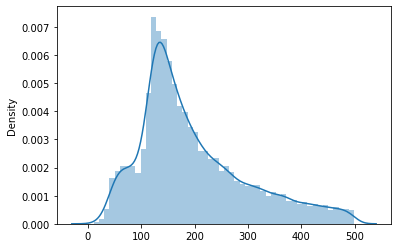

In [ ]:
import seaborn as sns
%matplotlib inline

sns.distplot(long_crit);

Usando el preprocesamiento de keras completamos las secuencias con valores irrelevantes introducidos previamente  (0 es el símbolo elegido), hasta que todas tienen longitud 500.

In [ ]:
X_train.shape, X_test.shape

((22882,), (23065,))

In [ ]:
X_train = sequence.pad_sequences(X_train, padding='pre',maxlen=max_len)
X_test = sequence.pad_sequences(X_test, padding='pre',maxlen=max_len)

In [ ]:
X_train.shape, X_test.shape

((22882, 500), (23065, 500))

In [ ]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Aplicamos LSTM

Vamos a generar ahora una LSTM con dos capas:
   - `Embedding` - Es la capa que transforma los índices enteros en vectores densos de longitud 32 para que las capas posteriores puedan procesarlos.
   - `LSTM` - Es la capa que trabaja en la clasificación. Ponemos 200 neuronas.
   - Una única neurona de salida con un sigmoide ya que estamos ante una clasificación 0-1 (crítica positiva, crítica negativa)

In [ ]:
embedding_vector_length=32

def modelLSTM(n_lstm):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_len))
    model.add(LSTM(n_lstm))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
rnn = modelLSTM(100)

In [ ]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#entrenamos el modelo
rnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
358/358 [==============================] - 20s 38ms/step - loss: 0.4784 - accuracy: 0.7783 - val_loss: 0.3541 - val_accuracy: 0.8488
Epoch 2/3
358/358 [==============================] - 15s 41ms/step - loss: 0.2868 - accuracy: 0.8858 - val_loss: 0.3143 - val_accuracy: 0.8714
Epoch 3/3
358/358 [==============================] - 15s 41ms/step - loss: 0.2446 - accuracy: 0.9053 - val_loss: 0.2998 - val_accuracy: 0.8751


In [ ]:
scores = rnn.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

721/721 [==============================] - 7s 9ms/step - loss: 0.2998 - accuracy: 0.8751
Accuracy: 87.51%


Con la primera prueba usando LSTM nos ubicamos en una precisión del 86.67% en el dataset, del artículo https://cs224d.stanford.edu/reports/HongJames.pdf sabemos que precisiones desarrolladas son

<img src='imdbresults.png'>

# GRU

In [ ]:
?GRU

In [ ]:
def modelGRU(n_gru):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_len))
    model.add(GRU(n_gru))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
rnnGRU=modelGRU(100)
rnnGRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 32)           160000    
                                                                 
 gru_4 (GRU)                 (None, 100)               40200     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 200,301
Trainable params: 200,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#entrenamos el modelo
rnnGRU.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
358/358 [==============================] - 15s 36ms/step - loss: 0.4348 - accuracy: 0.7875 - val_loss: 0.3224 - val_accuracy: 0.8621
Epoch 2/3
358/358 [==============================] - 10s 29ms/step - loss: 0.2750 - accuracy: 0.8889 - val_loss: 0.3218 - val_accuracy: 0.8704
Epoch 3/3
358/358 [==============================] - 10s 29ms/step - loss: 0.2334 - accuracy: 0.9097 - val_loss: 0.3184 - val_accuracy: 0.8692


In [ ]:
scores = rnnGRU.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

721/721 [==============================] - 6s 8ms/step - loss: 0.3184 - accuracy: 0.8692
Accuracy: 86.92%


### GRU regularizado con dropout

Usando celdas GRU hemos tardado menos y hemos mejorado ligeramente la precisión. Vamos a probar una versión regularizada del algoritmo con más epochs y neuronas para observar si mejora la precisión:

**NOTA: SI SE EJECUTA CON RECURRENT DROPOUT NO SE USA CUDNN KERNEL Y ES MUCHO MAS LENTO**

In [ ]:
from tensorflow.keras.regularizers import l2


def modelGRUdrop(n_gru,p_drop_W, l2_lambda=1e-5):
    reg_obj = l2(l2_lambda)
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_len))
    model.add(GRU(n_gru, dropout=p_drop_W, kernel_regularizer=reg_obj)) # recurrent_dropout=p_drop_U,
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
rnnGRUdrop=modelGRUdrop(n_gru=200, p_drop_W=0.4, l2_lambda=1e-5)
rnnGRUdrop.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 500, 32)           160000    
                                                                 
 gru_11 (GRU)                (None, 200)               140400    
                                                                 
 dense_12 (Dense)            (None, 1)                 201       
                                                                 
Total params: 300,601
Trainable params: 300,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#entrenamos el modelo
rnnGRUdrop.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Epoch 1/3
358/358 [==============================] - 17s 42ms/step - loss: 0.5495 - accuracy: 0.7127 - val_loss: 0.3806 - val_accuracy: 0.8392
Epoch 2/3
358/358 [==============================] - 15s 41ms/step - loss: 0.3332 - accuracy: 0.8601 - val_loss: 0.4085 - val_accuracy: 0.8384
Epoch 3/3
358/358 [==============================] - 15s 41ms/step - loss: 0.2898 - accuracy: 0.8849 - val_loss: 0.4327 - val_accuracy: 0.8180


In [ ]:
scores = rnnGRUdrop.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

721/721 [==============================] - 8s 11ms/step - loss: 0.4327 - accuracy: 0.8180
Accuracy: 81.80%


La regularización ha mejorado la precisión

In [ ]:
def modelGRUdrop2(n_gru,n_dense,p_drop_W,p_drop_U):
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_len))
    model.add(GRU(n_gru,dropout_W=p_drop_W,dropout_U=p_drop_U))
    model.add(Dense(n_dense, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
rnnGRUdrop = modelGRUdrop2(200,200,0.1,0.1)

In [ ]:
rnnGRUdrop.fit(X_train, y_train, validation_data=(X_test, y_test),
               nb_epoch=5, batch_size=64)

Train on 25000 samples, validate on 20947 samples
Epoch 1/5
25000/25000 [==============================] - 164s - loss: 0.5014 - acc: 0.7514 - val_loss: 0.3890 - val_acc: 0.8248
Epoch 2/5
25000/25000 [==============================] - 162s - loss: 0.3597 - acc: 0.8442 - val_loss: 0.4549 - val_acc: 0.7809
Epoch 3/5
25000/25000 [==============================] - 161s - loss: 0.2682 - acc: 0.8923 - val_loss: 0.3090 - val_acc: 0.8704
Epoch 4/5
25000/25000 [==============================] - 161s - loss: 0.2017 - acc: 0.9208 - val_loss: 0.2826 - val_acc: 0.8854
Epoch 5/5
25000/25000 [==============================] - 161s - loss: 0.1548 - acc: 0.9405 - val_loss: 0.3029 - val_acc: 0.8906


In [ ]:
scores = rnnGRUdrop.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

20947/20947 [==============================] - 62s    
Accuracy: 89.06%
